In [25]:
%config InlineBackend.figure_formats={'retina', 'pdf'}
%config InlineBackend.figure_dpi = 96

# The Pelton Cole-Cole model

## Introduction

## Exploring the parameter space

In [6]:
import os

import numpy as np
import bisip
from bisip import PeltonColeCole

np.random.seed(42)

# This will get one of the example data files in the BISIP package
fp = f'data/SIP-K389174.dat'
fp = os.path.join(os.path.dirname(bisip.__file__), fp)

# Define MCMC parameters and ColeCole model
nwalkers = 32
nsteps = 1000
model = PeltonColeCole(filepath=fp, nwalkers=nwalkers, nsteps=nsteps)
# Fit model to data
model.fit()

100%|██████████| 1000/1000 [00:01<00:00, 691.15it/s]


As always let's look at the parameter traces first.

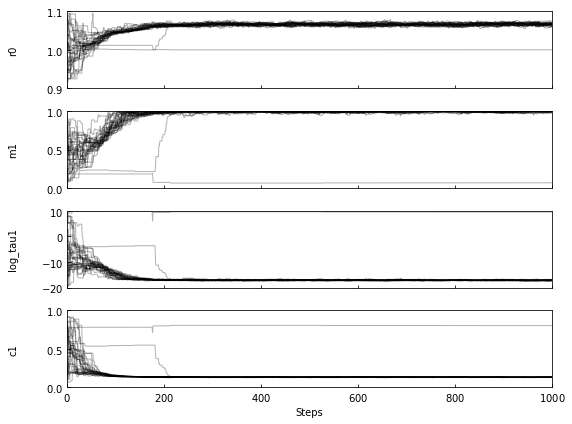

In [9]:
fig = model.plot_traces()

It looks like some chains were stuck in local minima, but overall one might think that the chains have reached a stationary state in most cases. However, we note that the chain for $m_1$ has hit the parameter boundary ($m_1 \to 1$). Let's look at the fit quality, discarding the first 500 steps to see what happens.

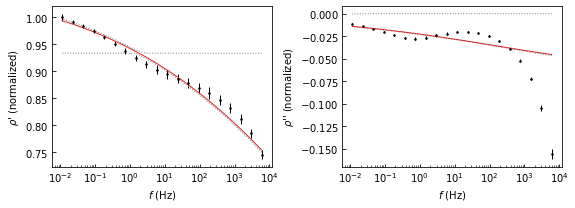

In [7]:
# Plot the fit by discarding the first 500 steps
fig = model.plot_fit(discard=500)

Not good. clearly, our data is not well represented by the default ColeCole `n_modes=1`. In fact, we see two bumps in the imaginary part of the resistivity spectra (the first at 1 Hz and the second at > 10 kHz. Let's redefine our model with `n_modes = 2`, `nsteps = 5000` and `nwalkers = 64`. We run the simulation for more steps with more walkers because the number of parameters to solve has increased.

In [15]:
# Add the n_modes = 2 argument.
nsteps = 5000
n_modes = 2
nwalkers = 64
model = PeltonColeCole(filepath=fp, nwalkers=nwalkers, nsteps=nsteps, n_modes=n_modes)
# Fit model to data
model.fit()

100%|██████████| 5000/5000 [00:10<00:00, 458.67it/s]


Let's check the traces again. We expect two values for $m$, $\log \tau$ and $c$ because we have two Cole-Cole modes.

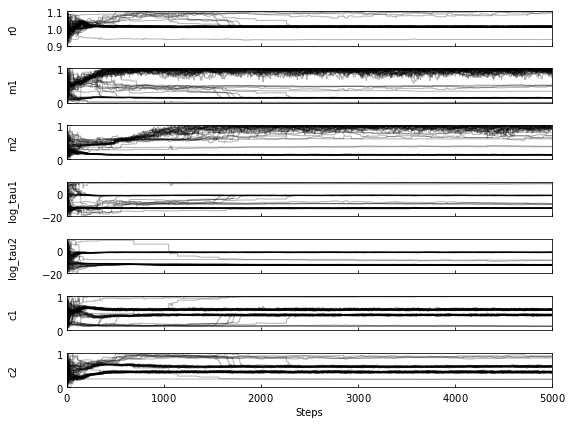

In [13]:
fig = model.plot_traces()

This is quite interesting. It's not even worth yet to look at the fit quality, because the parameter traces tell us that there are at least two possible solutions to the inverse problem. This is because both Cole-Cole modes are interchangeable -- meaning that mode 1 can take on the parameters of mode 2 and vice versa. We will now see how to fix this problem by adjusting the parameter boundaries.

First we note that $\log \tau_1$ has two solutions: one around 0 and another around -15. The same is true for $\log \tau_2$. We will fix $\log \tau_1$ so that its values is constrained between -5 and +5, and fix the $\log \tau_2$ to be constrained between -10 and -20.

In [27]:
# Adjust the boundaries
model.params.update(log_tau1=[-5, 5], log_tau2=[-20, -10])
model.p0 = None  # here we reset the randomly selected initial values

Next we fit the model using these new boundaries and visualize the traces.

100%|██████████| 5000/5000 [00:12<00:00, 393.59it/s]


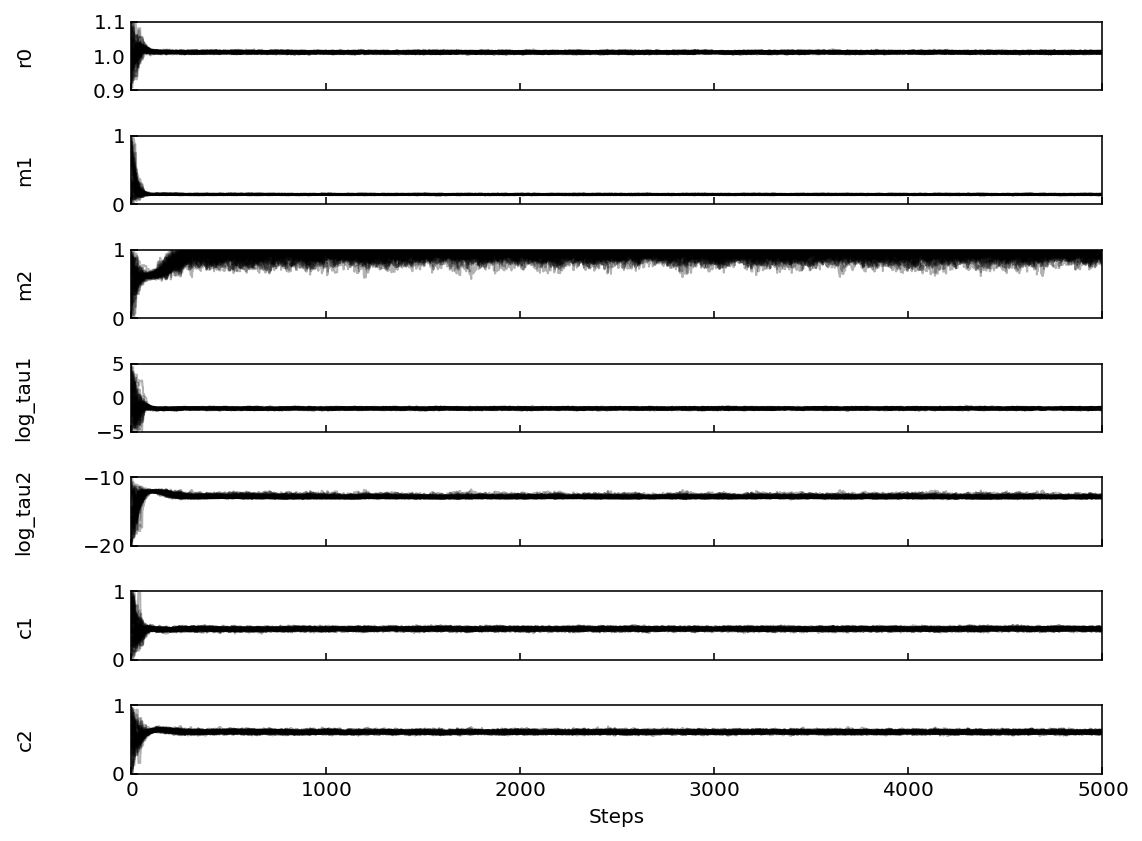

In [28]:
model.fit()
fig = model.plot_traces()

Amazing! The stricter priors have allowed all 64 walkers to find a unique solution. With these improved parameter chains the fit quality should be improved. Let's plot the fit quality while discarding the first 1000 steps.

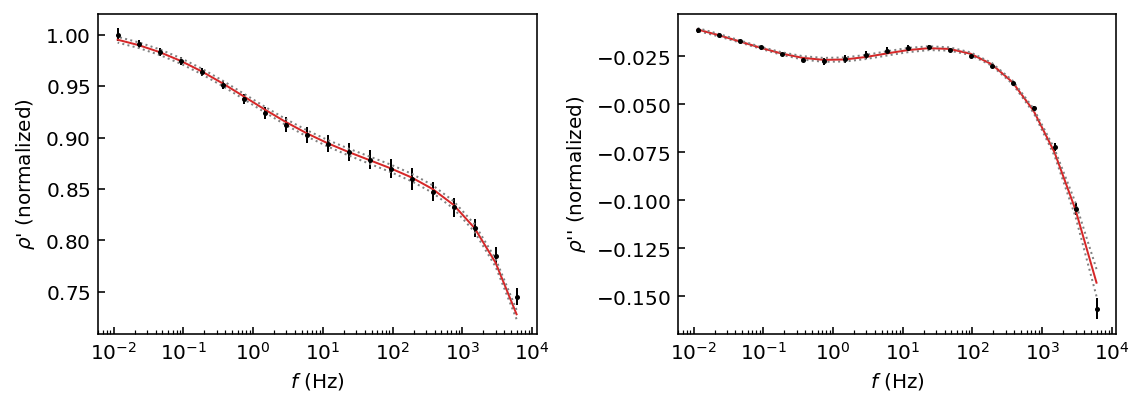

In [30]:
# Extract the chain 
chain = model.get_chain(discard=1000, thin=10, flat=True)

# Plot the fit by discarding the first 1000 steps
fig = model.plot_fit(chain)

The adjustment is satisfying, and the 95% HPD reasonable if we consider the relatively small measurement error bars. Let's inspect the mean parameters and their uncertainties.

In [41]:
from IPython.display import display, Math

# Print the mean and std of the parameters after discarding burn-in samples
values = model.get_param_mean(chain)
uncertainties = model.get_param_std(chain)

for n, v, u in zip(model.param_names, values, uncertainties):
    txt = '{0}: {1:.3f} \pm {2:.3f}'
    n = '\\'+n.replace('_', '\\')
    n = n.replace('\\r0', '\\rho_0')
    n = n.replace('\\m', 'm_')
    n = n.replace('\\c', 'c_')
    n = n.replace('\\tau', '\\tau_')
    txt = txt.format(n, v, u)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

It looks like the parameters are very well resolved, and due to the small data error bars the uncertainties on the Pelton parameters are also very small (but you should still not neglect them). We will now visualize the posterior distribution of the Pelton model with the `plot_corner` method.

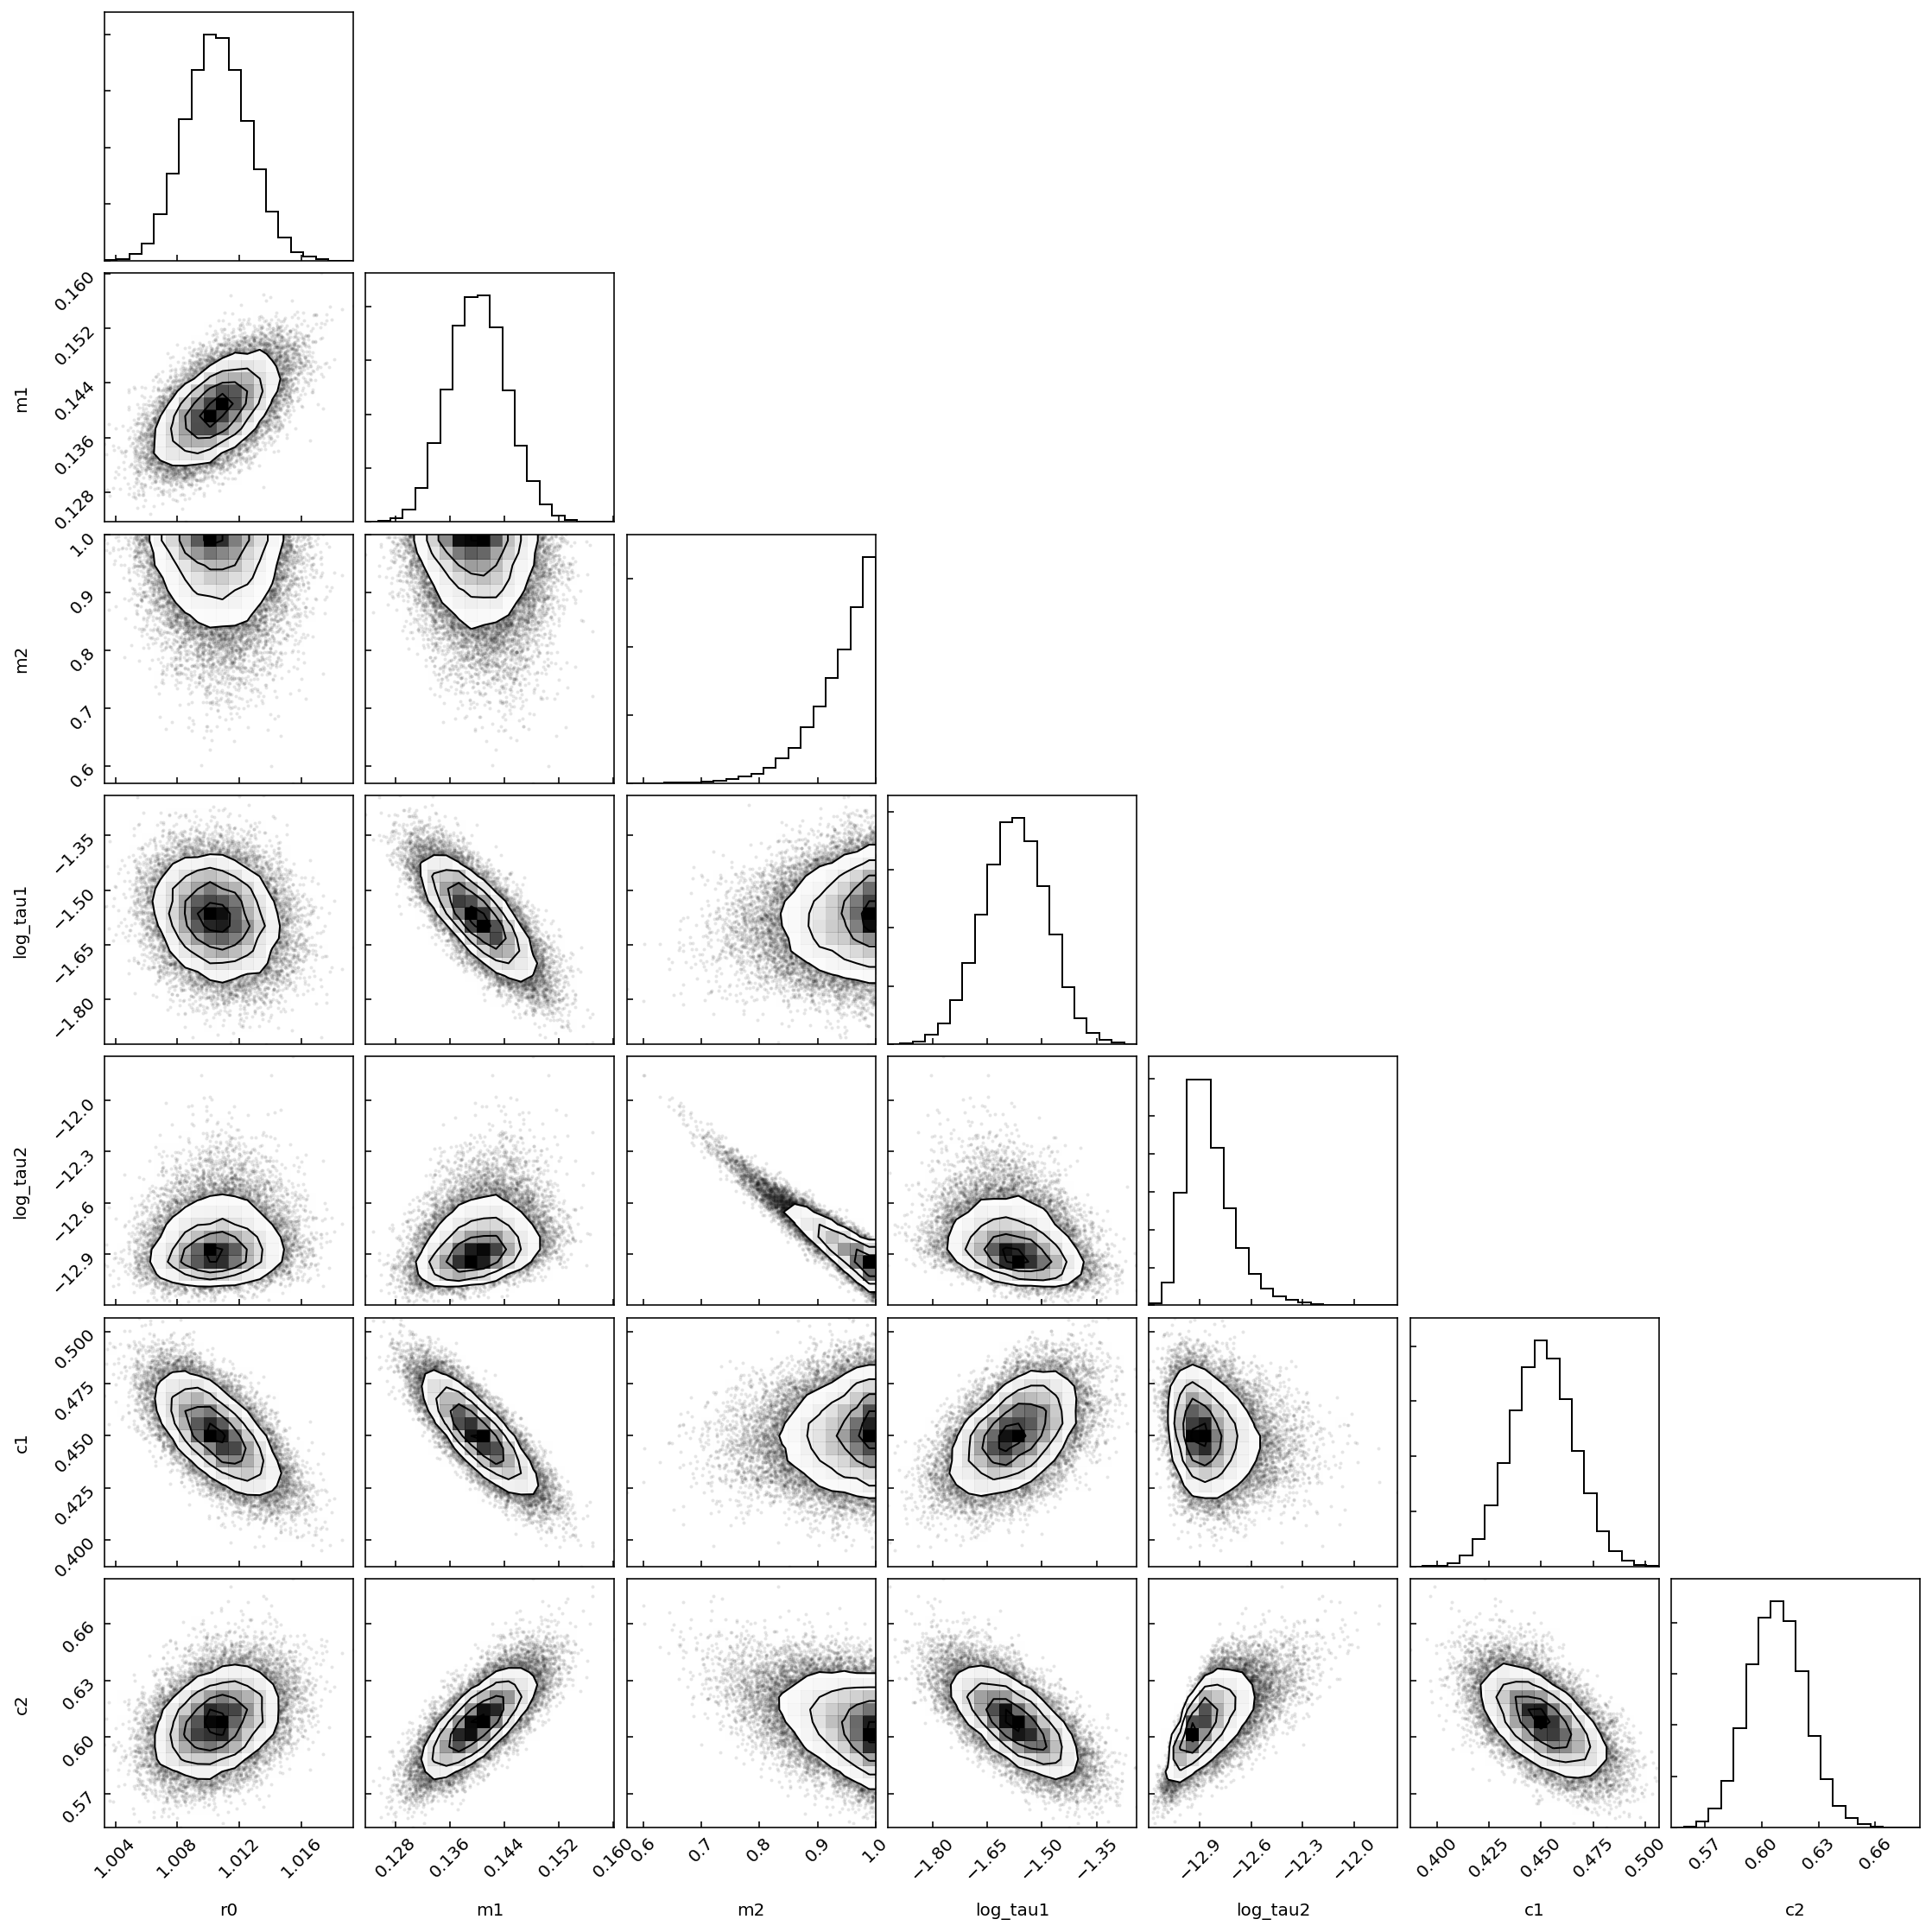

In [31]:
# Plot the posterior of the Pelton model using our chain
fig = model.plot_corner(chain)

The corner plot shows interesting correlations between various parameters. More importantly, it shows that our $m_2$ parameter has accumulated at $m_2 \to 1$. This tells us that although the fit quality is good, the Pelton model does not explain well our data set.

## Conclusions

From this experiment, we conclude that the $\rho_0$ parameter is relatively
independent from the others. We observed a similar result in the Dias model tutorial. We also learned that the Pelton Cole-Cole modes are interchangeable, and that to avoid this problem we must fix the $\log \tau_k$ parameters to take on boundaries that do not overlap. Finally, it appears that the $m_2$ parameter was not well resolved because it has accumulated at its upper limit. This implies that even higher values of $m_2$ may explain our data better. However, because $m$ is defined in the interval $[0, 1]$ our results suggest that the Pelton Cole-Cole model may not explain well our data set, especially its high-frequency response.